# Import Packages and Data

In [81]:
# Data manipulation
import numpy as np
import pandas as pd
from datetime import datetime
import calendar


# Plots
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plt.style.use('fast')

# Modelado y Forecasting
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

# Warnings configuration
import warnings
warnings.filterwarnings('ignore')

In [82]:
# Import data
path = '/Users/Lenovo\OneDrive - Imperial College London/Spring 2022/Energy Analytics/Forecasting/Forecasting_Competition_InCampus-main'

time_series = pd.read_excel(path + '/DatasetOnCampus1403.xlsx', 'Demand')
temperature = pd.read_excel(path + '/DatasetOnCampus1403.xlsx', 'Temperature')
sunshine = pd.read_excel(path + '/DatasetOnCampus1403.xlsx', 'Sunshine Duration')

# Process Temperature Data

In [83]:
temperature = temperature.rename(columns={'Unnamed: 0' : 'Date'})

# Select only the past temperature recordings (not forecasts)
temperature_past = temperature.iloc[:-8,]

# Group by the mean of every 4 temperature values since there are 4 weather forecasts per day
temperature_mean = temperature_past.groupby(np.arange(len(temperature_past))//4).mean()

# Restore date column
temperature_mean['Date'] = pd.date_range(start='1/1/2018', periods=len(temperature_mean), freq='1D')

# Take the average temperature across the 3 cities in a day
temperature_mean['Avg_Temp'] = temperature_mean[['Bristol Temperature [Celsius]', 'London Temperature [Celsius]', 'Leeds Temperature [Celsius]']].mean(axis=1)

temperature_final = temperature_mean[['Date','Avg_Temp']]
temperature_final

,Date,Avg_Temp
0,2018-01-01,6.276670
1,2018-01-02,6.920143
2,2018-01-03,7.670420
3,2018-01-04,7.015282
4,2018-01-05,5.393059
...,...,...
1528,2022-03-09,8.960374
1529,2022-03-10,9.978013
1530,2022-03-11,9.443846
1531,2022-03-12,9.088429


Research shows that most people in the UK turn their heaters on when the temperature drops below 14 degrees. We will compute the average temperature for each month of the year.

matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


<BarContainer object of 12 artists>

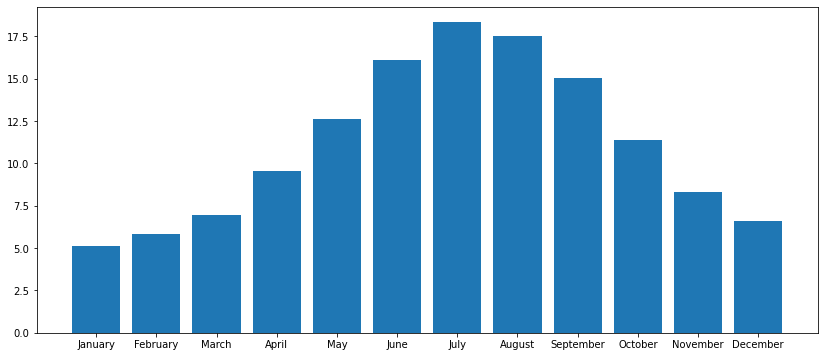

In [84]:
# Check the temperature trends across months of the year
temperature['month'] = pd.DatetimeIndex(temperature['Date']).month_name()
temperature_bymonth = temperature.groupby('month').mean().reset_index()
temperature_bymonth['Avg_Temp'] = temperature_bymonth[['Bristol Temperature [Celsius]', 'London Temperature [Celsius]', 'Leeds Temperature [Celsius]']].mean(axis=1)
temperature_by_month = temperature_bymonth[['month', 'Avg_Temp']]

# Sort the rows by month
months = ["January", "February", "March", "April", "May", "June", 
          "July", "August", "September", "October", "November", "December"]
temperature_by_month['month'] = pd.Categorical(temperature_by_month['month'], categories=months, ordered=True)
temperature_by_month = temperature_by_month.sort_values('month')

temperature_by_month
figure_name = plt.figure(figsize=(14, 6))
plt.bar(x=temperature_by_month['month'], height=temperature_by_month['Avg_Temp'], color='C0')

# Process Sunshine Table

In [85]:
sunshine = sunshine.rename(columns={'Unnamed: 0' : 'Date'})
sunshine['Avg_Sunlight'] = sunshine[['Bristol Sunshine [minutes]', 'London Sunshine [minutes]', 'Leeds Sunshine [minutes]']].mean(axis=1)
sunshine_final = sunshine[['Date','Avg_Sunlight']].iloc[:-2]
sunshine_final

,Date,Avg_Sunlight
0,2018-01-01,271.262408
1,2018-01-02,34.192317
2,2018-01-03,198.249705
3,2018-01-04,71.796514
4,2018-01-05,165.103902
...,...,...
1528,2022-03-09,253.382976
1529,2022-03-10,297.755320
1530,2022-03-11,110.515956
1531,2022-03-12,222.732799


# Merge Past Data and Add Parameters

**Proposed Method:**  
1) *Heating effect*: we assume that most of the change in electricity demand that is associated with temperature is due to the heating during  the cold months of the year. According to research, most people in the UK turn on their heating when the temperature drops below 14 degress Celcius. Therefore, we create a dummy variable **HEATERS_ON** which is equal to 1 during the months where the average temperature is below 14 and 0 otherwise.  
Additionally, we will create an interaction between the average temperature and the **HEATERS_ON** variable to explain the varying response of electricity demand to a change in temperature and call it **Avg_Temp*HEATERS_ON**  

2) *Weekday effect*: electricity demand is expected to drop on weekends. Therefore, we create a dummy variable **WEEKDAY** which is equal to 1 when it is a weekday and 0 otherwise.

In [86]:
join1 = time_series.merge(temperature_final, how = 'inner', left_on = 'SETTLEMENT_DATE', right_on = 'Date').drop('Date', axis=1)
data_final = join1.merge(sunshine_final, how = 'inner', left_on = 'SETTLEMENT_DATE', right_on = 'Date').drop('Date', axis=1)

# Check the shape of the data
print(time_series.shape, temperature_final.shape, join1.shape)
print(sunshine_final.shape, join1.shape, data_final.shape)


# Weekend or Weekday
data_final['Weekday'] = data_final['SETTLEMENT_DATE'].dt.dayofweek

weekday = []
for day in data_final['Weekday'].values.tolist():
    if day in range(0,5):
        weekday.append(1)
    else:
        weekday.append(0)
data_final['WEEKDAY'] = weekday 

data_final = data_final.drop('Weekday', axis = 1)


# Cold Season?
heaters_on = []
cold = ['October', 'November', 'December', 'January', 'February', 'March']

for date in data_final['SETTLEMENT_DATE']:
    if date.month_name() in cold:
        heaters_on.append(1)
    else:
        heaters_on.append(0)

data_final['HEATERS_ON'] = heaters_on
data_final = data_final.set_index('SETTLEMENT_DATE').rename(columns={'ENGLAND_WALES_DEMAND [MW]':'Demand [MW]'})
data_final['log_demand'] = np.log(data_final['Demand [MW]'])
data_final['HEATERS_ON*Avg_Temp'] = data_final['Avg_Temp'] * data_final['HEATERS_ON']
data_final = data_final[[ 'log_demand', 'Avg_Temp', 'Avg_Sunlight', 'WEEKDAY', 'HEATERS_ON', 'HEATERS_ON*Avg_Temp']]

# Take log of Demand
data_final

(1533, 2) (1533, 2) (1533, 3)
(1533, 2) (1533, 3) (1533, 4)


,log_demand,Avg_Temp,Avg_Sunlight,WEEKDAY,HEATERS_ON,HEATERS_ON*Avg_Temp
SETTLEMENT_DATE,,,,,,
2018-01-01,10.182113,6.276670,271.262408,1,1,6.276670
2018-01-02,10.378343,6.920143,34.192317,1,1,6.920143
2018-01-03,10.358237,7.670420,198.249705,1,1,7.670420
2018-01-04,10.401004,7.015282,71.796514,1,1,7.015282
2018-01-05,10.421214,5.393059,165.103902,1,1,5.393059
...,...,...,...,...,...,...
2022-03-09,10.225633,8.960374,253.382976,1,1,8.960374
2022-03-10,10.216360,9.978013,297.755320,1,1,9.978013
2022-03-11,10.211947,9.443846,110.515956,1,1,9.443846


# New Data and Exogenous Variables

In [87]:
# Select only the forecasted sunshine and temperature values values 
sunshine_forecast = sunshine.iloc[-2:]
temperature_forecast = temperature.iloc[-8:]

# Group by every 4 temperature forecast values
temperature_forecast_m = temperature_forecast.groupby(np.arange(len(temperature_forecast))//4).mean()

# Restore the date values and add columns
temperature_forecast_m.index = sunshine_forecast.index
exogenous_predict = temperature_forecast_m
exogenous_predict['Avg_Sunlight'] = sunshine_forecast['Avg_Sunlight']
exogenous_predict['Date'] = sunshine_forecast['Date']
exogenous_predict['Avg_Temp'] = exogenous_predict[['Bristol Temperature [Celsius]', 'London Temperature [Celsius]', 'Leeds Temperature [Celsius]']].mean(axis=1)


# Since our analysis is in 
exogenous_predict['HEATERS_ON'] = 1

# Weekend or Weekday
exogenous_predict['Weekday'] = exogenous_predict['Date'].dt.dayofweek

weekday1 = []
for day in exogenous_predict['Weekday'].values.tolist():
    if day in range(0,5):
        weekday1.append(1)
    else:
        weekday1.append(0)
        
exogenous_predict['WEEKDAY'] = weekday1 

exogenous_predict = exogenous_predict.drop('Weekday', axis = 1)

exogenous_predict['HEATERS_ON*Avg_Temp'] = exogenous_predict['Avg_Temp'] * exogenous_predict['HEATERS_ON']

exogenous_predict = exogenous_predict[['Date','Avg_Temp', 'Avg_Sunlight', 'WEEKDAY', 'HEATERS_ON', 'HEATERS_ON*Avg_Temp']]


exogenous_predict

,Date,Avg_Temp,Avg_Sunlight,WEEKDAY,HEATERS_ON,HEATERS_ON*Avg_Temp
1533,2022-03-14,7.674679,581.110695,1,1,7.674679
1534,2022-03-15,9.250000,60.000000,1,1,9.250000


# Split Data into Training/Test

In [88]:
data_train = data_final.iloc[0:1500,:]
data_test = data_final.iloc[1500:,:]

print(f"Train dates      : {data_train.index.min()} --- {data_train.index.max()}")
print(f"Test dates       : {data_test.index.min()} --- {data_test.index.max()}")

Train dates      : 2018-01-01 00:00:00 --- 2022-02-08 00:00:00
Test dates       : 2022-02-09 00:00:00 --- 2022-03-13 00:00:00


# Explore Seasonality

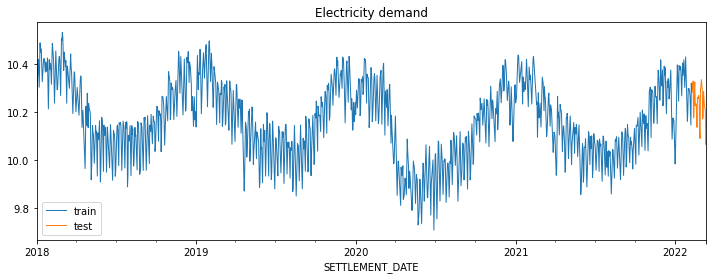

In [89]:
# Time series plot
fig, ax = plt.subplots(figsize=(12, 4))
data_train.log_demand.plot(ax=ax, label='train', linewidth=1)
data_test.log_demand.plot(ax=ax, label='test', linewidth=1)
ax.set_title('Electricity demand')
ax.legend()

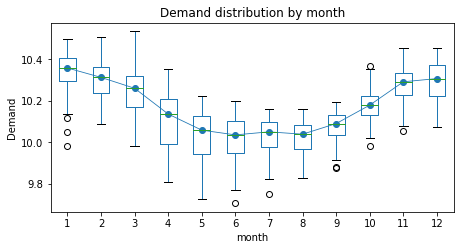

In [90]:
# Boxplot for annual seasonality
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3.5))
data_final['month'] = data_final.index.month
data_final.boxplot(column='log_demand', by='month', ax=ax,)
data_final.groupby('month')['log_demand'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Demand')
ax.set_title('Demand distribution by month')
fig.suptitle('');

# Autocorrelation Plot

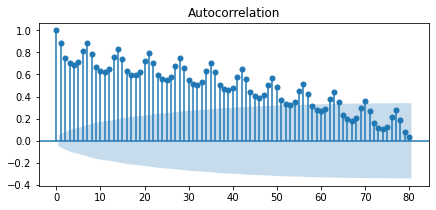

In [91]:
# Autocorrelation plot
# ==============================================================================
fig, ax1 = plt.subplots(figsize=(7, 3))
ax1.set_facecolor("white")
ax1.grid(False)
plot_acf(data_final.log_demand, ax=ax1, lags=80)
plt.show()

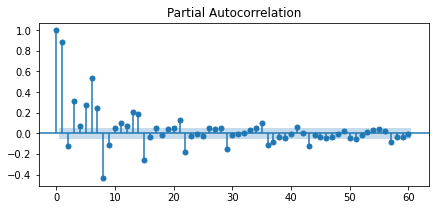

In [92]:
# Partial autocorrelation plot
# ==============================================================================
fig, ax2 = plt.subplots(figsize=(7, 3))
ax2.set_facecolor("white")
ax2.grid(False)
plot_pacf(data_final.log_demand, ax=ax2, lags=60)
plt.show()

Text(0.5, 0.98, 'Horizontally stacked subplots')

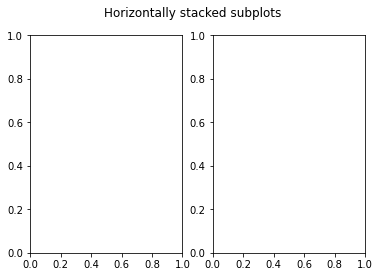

In [93]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Horizontally stacked subplots')

The autocorrelation plot shows that there is a strong and significant positive correlation between the daily demand for electricity and its previous values. This indicates that an autoregressive model would be useful.

# Initial Autoregression Model 

Start with lags=7 (will tune later)

In [94]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = make_pipeline(StandardScaler(), Ridge()),
                lags      = 7
             )

forecaster.fit(y=data_train.loc[:, 'log_demand'], exog=data_train[['WEEKDAY', 'Avg_Temp', 'Avg_Sunlight', 'HEATERS_ON', 'HEATERS_ON*Avg_Temp']])
forecaster

ForecasterAutoreg 
Regressor: Pipeline(steps=[('standardscaler', StandardScaler()), ('ridge', Ridge())]) 
Lags: [1 2 3 4 5 6 7] 
Window size: 7 
Included exogenous: True 
Type of exogenous variable: <class 'pandas.core.frame.DataFrame'> 
Exogenous variables names: ['WEEKDAY', 'Avg_Temp', 'Avg_Sunlight', 'HEATERS_ON', 'HEATERS_ON*Avg_Temp'] 
Training range: [0, 1499] 
Training index type: RangeIndex 
Training index frequency: 1 
Regressor parameters: {'standardscaler__copy': True, 'standardscaler__with_mean': True, 'standardscaler__with_std': True, 'ridge__alpha': 1.0, 'ridge__copy_X': True, 'ridge__fit_intercept': True, 'ridge__max_iter': None, 'ridge__normalize': 'deprecated', 'ridge__positive': False, 'ridge__random_state': None, 'ridge__solver': 'auto', 'ridge__tol': 0.001} 
Creation date: 2022-03-27 12:16:02 
Last fit date: 2022-03-27 12:16:02 
Skforecast version: 0.4.2 

In [95]:
# Backtest with training data
# ==============================================================================
metric, predictions = backtesting_forecaster(
                            forecaster = forecaster,
                            y          = data_final.log_demand,
                            initial_train_size = len(data_train),
                            steps      = 2,
                            metric     = 'mean_absolute_error',
                            refit = False,
                            verbose    = True
                        )

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 1500
Number of observations used for backtesting: 33
    Number of folds: 17
    Number of steps per fold: 2
    Last fold only includes 1 observations

Data partition in fold: 0
    Training:   2018-01-01 00:00:00 -- 2022-02-08 00:00:00
    Validation: 2022-02-09 00:00:00 -- 2022-02-10 00:00:00
Data partition in fold: 1
    Training:   2018-01-01 00:00:00 -- 2022-02-08 00:00:00
    Validation: 2022-02-11 00:00:00 -- 2022-02-12 00:00:00
Data partition in fold: 2
    Training:   2018-01-01 00:00:00 -- 2022-02-08 00:00:00
    Validation: 2022-02-13 00:00:00 -- 2022-02-14 00:00:00
Data partition in fold: 3
    Training:   2018-01-01 00:00:00 -- 2022-02-08 00:00:00
    Validation: 2022-02-15 00:00:00 -- 2022-02-16 00:00:00
Data partition in fold: 4
    Training:   2018-01-01 00:00:00 -- 2022-02-08 00:00:00
    Validation: 2022-02-17 00:00:00 -- 2022-0

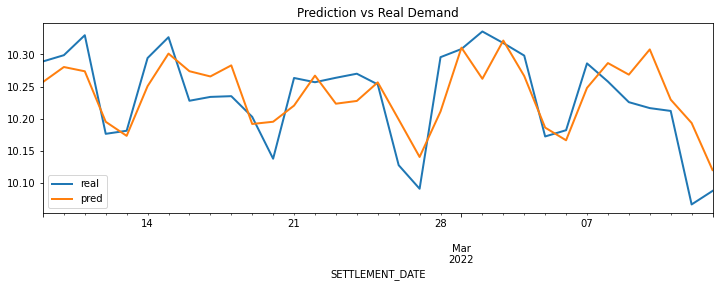

In [96]:
# Plot
# ==============================================================================
predictions['SETTLEMENT_DATE'] = data_test.index
predictions = predictions.set_index('SETTLEMENT_DATE')
fig, ax = plt.subplots(figsize=(12, 3.5))
data_final.loc[predictions.index, 'log_demand'].plot(ax=ax, linewidth=2, label='real') # test data
predictions.plot(linewidth=2, label='prediction', ax=ax)
ax.set_title('Prediction vs Real Demand')
ax.legend()

# Hyperparameter Tuning

In [97]:
# Hyperparameter Grid search
# ==============================================================================
forecaster = ForecasterAutoreg(
                    regressor = make_pipeline(StandardScaler(), Ridge()),
                    lags      = 7 # This value will be replaced in the grid search
              )

# Regressor's hyperparameters
param_grid = {'ridge__alpha': np.logspace(-3, 5, 10)}

# Lags used as predictors
lags_grid = [7, 15, 30, 63, 80, 100, 150, 170, 200]

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = data_final.log_demand,
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 2,
                        metric      = 'mean_absolute_error',
                        refit       = False,
                        initial_train_size = len(data_train),
                        return_best = True,
                        verbose     = False
                  )

Number of models compared: 90


loop lags_grid: 100%|███████████████████████████████████████| 9/9 [00:04<00:00,  1.93it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150] 
  Parameters: {'ridge__alpha': 0.001}
  Backtesting metric: 0.02536303100227381



In [98]:
# forecaster is automatically trained according to the best found hyperparameters
# fit to to exogenous 
forecaster.fit(y=data_train.loc[:, 'log_demand'], exog=data_train[['WEEKDAY', 'Avg_Temp', 'Avg_Sunlight', 'HEATERS_ON', 'HEATERS_ON*Avg_Temp']])
forecaster

ForecasterAutoreg 
Regressor: Pipeline(steps=[('standardscaler', StandardScaler()),
                ('ridge', Ridge(alpha=0.001))]) 
Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150] 
Window size: 150 
Included exogenous: True 
Type of exogenous variable: <class 'pandas.core.frame.DataFrame'> 
Exogenous variables names: ['WEEKDAY', 'Avg_Temp', 'Avg_Sunlight', 'HEATERS_ON', 'HEATERS_ON*Avg_Temp'] 
Training range: [0, 1499] 
Trainin

In [99]:
# Backtest with training data
# ==============================================================================
metric, predictions = backtesting_forecaster(
                            forecaster = forecaster,
                            y          = data_final.log_demand,
                            initial_train_size = len(data_train),
                            steps      = 2,
                            metric     = 'mean_absolute_error',
                            interval            = [5, 95],
                            n_boot              = 500,
                            in_sample_residuals = True,
                            refit = False,
                            verbose    = True
                        )

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 1500
Number of observations used for backtesting: 33
    Number of folds: 17
    Number of steps per fold: 2
    Last fold only includes 1 observations

Data partition in fold: 0
    Training:   2018-01-01 00:00:00 -- 2022-02-08 00:00:00
    Validation: 2022-02-09 00:00:00 -- 2022-02-10 00:00:00
Data partition in fold: 1
    Training:   2018-01-01 00:00:00 -- 2022-02-08 00:00:00
    Validation: 2022-02-11 00:00:00 -- 2022-02-12 00:00:00
Data partition in fold: 2
    Training:   2018-01-01 00:00:00 -- 2022-02-08 00:00:00
    Validation: 2022-02-13 00:00:00 -- 2022-02-14 00:00:00
Data partition in fold: 3
    Training:   2018-01-01 00:00:00 -- 2022-02-08 00:00:00
    Validation: 2022-02-15 00:00:00 -- 2022-02-16 00:00:00
Data partition in fold: 4
    Training:   2018-01-01 00:00:00 -- 2022-02-08 00:00:00
    Validation: 2022-02-17 00:00:00 -- 2022-0

In [100]:
# Error backtest
# ==============================================================================
print(f'Backtest error: {metric}')
predictions['SETTLEMENT_DATE'] = data_test.index
predictions = predictions.set_index('SETTLEMENT_DATE')
predictions

Backtest error: [0.02536303]


,pred,lower_bound,upper_bound
SETTLEMENT_DATE,,,
2022-02-09,10.279683,10.213999,10.335789
2022-02-10,10.294014,10.216838,10.368587
2022-02-11,10.277084,10.211399,10.333189
2022-02-12,10.192317,10.115141,10.266889
2022-02-13,10.169573,10.103888,10.225678
2022-02-14,10.293467,10.216291,10.368039
2022-02-15,10.310777,10.245092,10.366883
2022-02-16,10.313801,10.236625,10.388373
2022-02-17,10.243066,10.177381,10.299172


In [101]:
# Coefficients
df = forecaster.get_coef()
df

,feature,coef
0,lag_1,0.096012
1,lag_2,0.004392
2,lag_3,0.010140
3,lag_4,-0.000201
4,lag_5,0.000791
...,...,...
150,WEEKDAY,0.046228
151,Avg_Temp,-0.000064
152,Avg_Sunlight,-0.013601
153,HEATERS_ON,0.035061


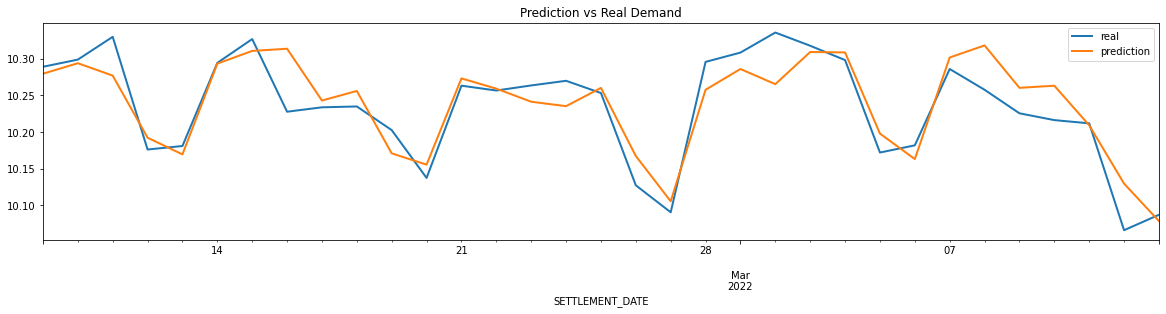

In [102]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(20, 4))
data_test['log_demand'].plot(linewidth=2, label='real', ax=ax)
predictions.iloc[:, 0].plot(linewidth=2, label='prediction', ax=ax)
ax.set_title('Prediction vs Real Demand')
ax.legend();

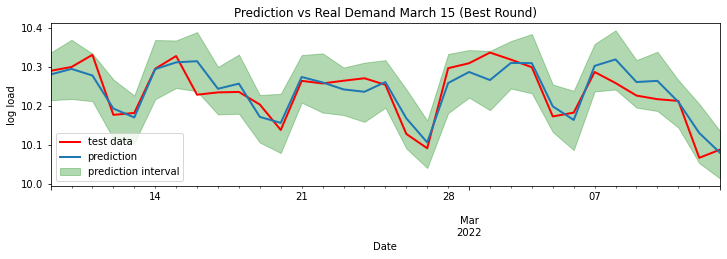

In [103]:
# Plot with interval
# ==============================================================================
fig, ax = plt.subplots(figsize=(12, 3))
data_test['log_demand'].plot(linewidth=2, label='test data', color='red', ax=ax)
predictions.iloc[:, 0].plot(linewidth=2, label='prediction', ax=ax)
ax.set_title('Prediction vs Real Demand March 15 (Best Round)')
plt.xlabel('Date')
plt.ylabel('log load')
ax.fill_between(
    predictions.index,
    predictions.iloc[:, 1],
    predictions.iloc[:, 2],
    alpha = 0.3,
    color = 'green',
    label = 'prediction interval' 
)
ax.legend();

In [104]:
# Predicted interval coverage
# ==============================================================================
inside_interval = np.where(
                     (data_test['log_demand'] >= predictions["lower_bound"]) & \
                     (data_test['log_demand'] <= predictions["upper_bound"]),
                     True,
                     False
                   )

coverage = inside_interval.mean()
print(f"Predicted interval coverage: {100 * coverage}")

Predicted interval coverage: 96.96969696969697


# Predicting the Future Values

In [105]:
forecaster.fit(y=data_final.loc[:, 'log_demand'], exog=data_final[['WEEKDAY', 'Avg_Temp', 'Avg_Sunlight', 'HEATERS_ON', 'HEATERS_ON*Avg_Temp']])

predictions_future = forecaster.predict_interval(
                    steps    = 2,
                    exog=exogenous_predict[['WEEKDAY', 'Avg_Temp', 'Avg_Sunlight', 'HEATERS_ON', 'HEATERS_ON*Avg_Temp']],
                    interval = [5, 95],
                    n_boot   = 500
              )

predictions_future = predictions_future.set_index(exogenous_predict['Date'])
predictions_future

,pred,lower_bound,upper_bound
Date,,,
2022-03-14,10.216304,10.156078,10.264336
2022-03-15,10.256467,10.190298,10.317331


In [106]:
# Standard deviation = (Upper bound - Prediction)/1.96 for a 95% prediction interval
sd = (predictions_future.iloc[1,2]- predictions_future.iloc[1,0])/1.96
sd

0.0310527679939699